## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [1]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [2]:
# take the logarithm of the traffic counts and subtract the mean of this vector as y
X = np.asarray(Data1[['Longitude','Latitude']])
y = np.asarray(np.log(Data1.AvgDailyTrafficCount)-np.log(Data1.AvgDailyTrafficCount).mean())

In [3]:
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.* RBF(length_scale=[1., 1.], length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

gp = GaussianProcessRegressor(kernel=kernel,random_state=1)
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=[1, 1]) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=1)

In [4]:
# 1)
# the kernel after parameter optimization and fitting to the observed data
print(gp.kernel_)

0.658**2 * RBF(length_scale=[0.0326, 0.0395]) + WhiteKernel(noise_level=0.568)


In [5]:
# 2)
# the log marginal likelihood of the training data
print(gp.log_marginal_likelihood_value_)

-1365.3239324369588


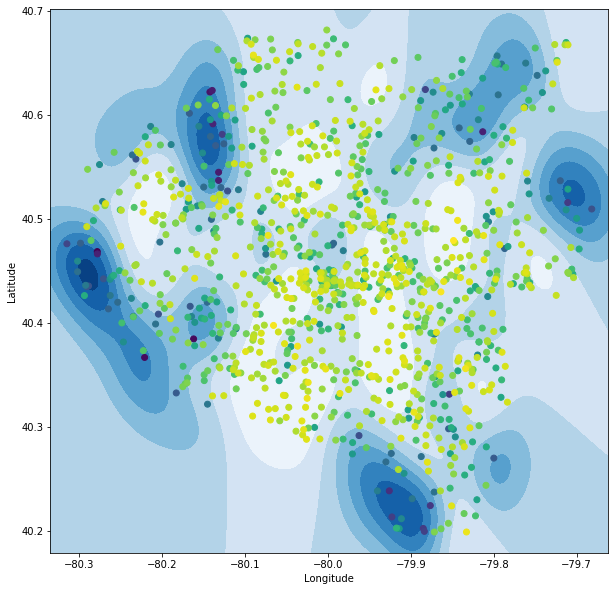

In [30]:
# 3)
# predict over a mesh grid of longitude/latitude
Long, Lat = np.meshgrid(np.linspace(Data1.Longitude.min()-0.02, Data1.Longitude.max()+0.02, 200), \
                       np.linspace(Data1.Latitude.min()-0.02, Data1.Latitude.max()+0.02, 200))
y_pred, y_std = gp.predict(np.c_[Long.ravel(), Lat.ravel()], return_std=True)
y_pred = y_pred.reshape(Long.shape)

# plot the model's predictions (with color corresponding to the predicted values)
plt.figure(figsize=(10,10))
plt.contourf(Long, Lat, y_pred, cmap=plt.cm.Blues_r)

# overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values)
a = plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [31]:
# 4)
y_pred, y_std= gp.predict(X, return_std=True)
percentage = (sum(y > y_pred + 2*y_std) + sum(y < y_pred - 2*y_std))/len(y)*100
print('The percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location is:',percentage,'%')

The percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location is: 4.2152466367713 %


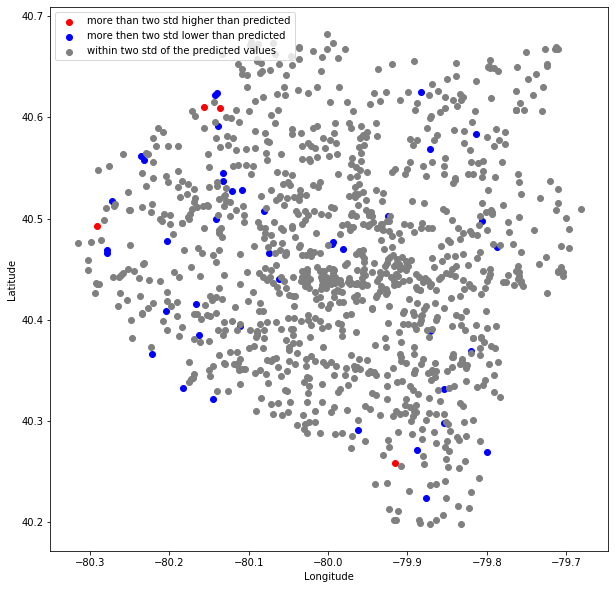

In [55]:
# 5)
# 2-D scatter plot of the sensor locations, with three colors corresponding to observed values 
#a) more than two standard deviations higher than predicted
#b) more then two standard deviations lower than predicted
#c) within two standard deviations of the predicted values
X_a = X[list(y > y_pred + 2*y_std)]
X_b = X[list(y < y_pred - 2*y_std)]
X_c = X[list((y_pred - 2*y_std <= y) & (y <= y_pred + 2*y_std))]

plt.figure(figsize=(10,10))

a = plt.scatter(X_a[:, 0], X_a[:, 1], c='red')
b = plt.scatter(X_b[:, 0], X_b[:, 1], c='blue')
c = plt.scatter(X_c[:, 0], X_c[:, 1], c='gray')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend([a, b, c],
           ["more than two std higher than predicted",
            "more then two std lower than predicted",
           "within two std of the predicted values"],
           loc="upper left")
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


(1,0) is Anomaly, because the closest cluster center is (0,0), yet the distance to it is 1 > 0.1, it doesn't fall into any cluster.

(35,2) is Not Anomaly, because the closest cluster center is (35,5), and the distance to it is 3 < 5, it falls into cluster B with other 150 points.

(15,19) is Anomaly, because the closest cluster center is (15,20), and the distance to it is 1 = 1, it falls into cluster C, but cluster C have only 2 points, which is too small compare to other clusters, and the points in it can be marked as anomaly.

(10,11) is Not Anomaly, because the closest cluster center is (10,10), and the distance to it is 1 = 1, it falls into cluster D with other 200 points.

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [58]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,"Sweetwater, Wyoming",14,3.4,3.2,9,19,29,8.2,26,91,...,12,4,26,9.5,429,91,11.9,10,77,18
3137,"Teton, Wyoming",11,3,3,6,15,13,7.9,11,98,...,10,3.8,19,19.3,299,47,10.2,20,63,11
3138,"Uinta, Wyoming",15,3.4,3.2,9,18,30,7.6,25,15,...,13,4.7,24,6.6,45,91,11.6,12,78,17
3139,"Washakie, Wyoming",14,3.3,3.3,6,16,25,8.2,22,61,...,16,4.5,29,22.5,70,83,10,9,70,12


In [141]:
# pre-processing
X = Data2[Data2.columns[1:]]
X = X.replace('?',np.nan)
X = X.replace(' ',np.nan)
X = X.dropna()
X = X.astype(float)
X

,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,19.0,4.4,4.3,9.0,19.0,31.0,7.1,29.0,71.0,15.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14.0,89.0,42.0
1,16.0,4.1,4.2,9.0,19.0,27.0,7.6,25.0,72.0,15.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15.0,84.0,37.0
2,26.0,4.9,4.7,12.0,21.0,41.0,5.1,33.0,45.0,12.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18.0,84.0,35.0
3,22.0,4.8,4.6,12.0,21.0,40.0,7.4,33.0,33.0,14.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13.0,84.0,46.0
4,21.0,4.6,4.5,7.0,19.0,32.0,8.3,29.0,26.0,14.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12.0,85.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,14.0,3.4,3.2,9.0,19.0,29.0,8.2,26.0,91.0,18.0,...,12.0,4.0,26.0,9.5,429.0,91.0,11.9,10.0,77.0,18.0
3137,11.0,3.0,3.0,6.0,15.0,13.0,7.9,11.0,98.0,22.0,...,10.0,3.8,19.0,19.3,299.0,47.0,10.2,20.0,63.0,11.0
3138,15.0,3.4,3.2,9.0,18.0,30.0,7.6,25.0,15.0,16.0,...,13.0,4.7,24.0,6.6,45.0,91.0,11.6,12.0,78.0,17.0
3139,14.0,3.3,3.3,6.0,16.0,25.0,8.2,22.0,61.0,15.0,...,16.0,4.5,29.0,22.5,70.0,83.0,10.0,9.0,70.0,12.0


In [143]:
# Part 1
X_1 = X[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]

for i in range(len(X_1.columns)):
    X_1.iloc[:,i] = pd.cut(X_1[X_1.columns[i]],5,labels=[0,1,2,3,4])[:]

X_1.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
0,1,2,0,1,1,3
1,1,2,0,1,1,3
2,2,4,0,2,3,3
3,2,4,0,1,2,3
4,1,2,0,1,2,3


In [145]:
# use HillClimbSearch and BicScore to learn the Bayesian network structure
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore

hc = HillClimbSearch(X_1, scoring_method=BicScore(X_1))
best_model = hc.estimate()

In [147]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianModel(best_model.edges())
model.fit(X_1, estimator=MaximumLikelihoodEstimator)

In [149]:
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print(thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

In [166]:
# compute anomalousness of each of the first 500 data records
exmp=X_1.apply(lambda x: LL(x,model),axis=1)

In [170]:
# top 5 counties have the lowest (most negative) log-likelihood values
pd.concat([Data2.County[list(exmp.sort_values().head(5).index)], exmp.sort_values().head(5).rename('log-likelihood value')], axis=1)

,County,log-likelihood value
1856,"New York, New York",-16.608495
221,"San Francisco, California",-14.827149
2027,"Roulette, North Dakota",-14.686742
1227,"Suffolk, Massachusetts",-14.457849
317,"District of Columbia, District of Columbia",-13.671439


In [179]:
# Part 2
# a) clustering with k-means
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=3,random_state=123)
scor=KM.fit_predict(X)

# distance to each cluster center
res=pd.DataFrame(KM.transform(X))

# compute each record's distance to the nearest cluster center as score
res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

# report the five counties which have the longest distances
pd.concat([Data2.County[list(res.score.sort_values(ascending=False).head(5).index)], res.score.sort_values(ascending=False).head(5).rename('Distance')], axis=1)

,County,Distance
1890,"Alleghany, North Carolina",1970.505640
1294,"Ontonagon, Michigan",1331.341087
96,"Coconino, Arizona",1207.512661
2304,"Washington, Pennsylvania",1018.028250
995,"Barren, Kentucky",917.063749


In [200]:
# b) clustering with Gaussian Mixture
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=123)
GM.fit(X)

# 5 most anomalous counties by log-likelihood
pd.concat([Data2.County[list(pd.Series(GM.score_samples(X)).sort_values().head(5).index)], pd.Series(GM.score_samples(X)).sort_values().head(5).rename('log likelihood')], axis=1)

,County,log likelihood
1890,"Alleghany, North Carolina",-197.420106
66,"Winston, Alabama",-133.042814
1444,"Marion, Mississippi",-131.452092
2158,"Harper, Oklahoma",-129.450559
1577,"Saline, Missouri",-126.696033


In [205]:
# Part 3
# use Isolation Forest for anomaly detection
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(18)

clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X)

# 5 most anomalous counties
Data2.County[list(pd.DataFrame(clf.decision_function(X)).set_index(X.index).sort_values(0).head(5).index)]

2415    Shannon, South Dakota
23            Dallas, Alabama
162        Phillips, Arkansas
1440     Leflore, Mississippi
94            Apache, Arizona
Name: County, dtype: object

#### Part 4
Most of the counties found to be anomalous in one model are not in others, except for Alleghany, North Carolina, which shows up in the results of the two cluster-based anomaly detection model. This is because the models are based on distance, cluster respectively with different measure of anomalousness, and the distance-based model is using different train set. Also, the results only shows the top 5 most anomalous counties, not all the anomalies, so the results are so different with each other.

The cities are identified as anomaly because some of its health indicators are significant different with other counties. For example, Washington,Pennsylvania is anomalous because of lower Physically Unhealthy Days Per Month, \% Children in Poverty, % Physically Inactive, and higher Food Environment Index and % With Access To Exercise.